# Importing necessary Libraries

# Import dataset

In [2]:
import os

dir = r'D:\Alzeimheir\Alzheimer_s Dataset'
labels = os.listdir(dir)
n_class = len(labels)

print(f"No of classes: {n_class}")


No of classes: 4


# Number of images per class

In [3]:
for label in labels:
    print(label, len(os.listdir(dir+'/'+label)))

MildDemented 896
ModerateDemented 64
NonDemented 3200
VeryMildDemented 2240


## Sample image from each class

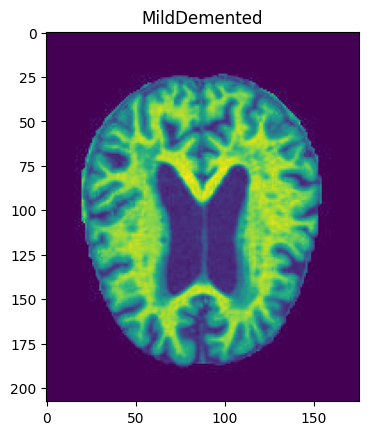

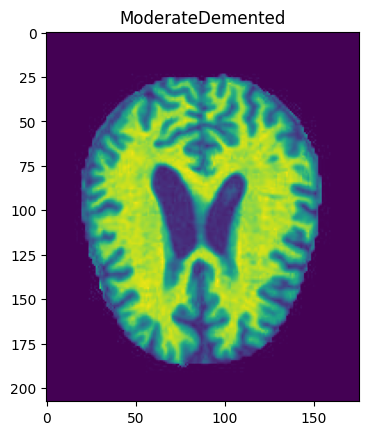

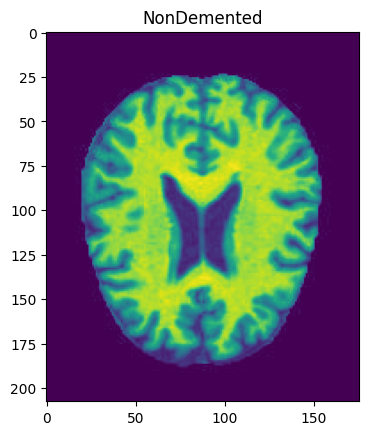

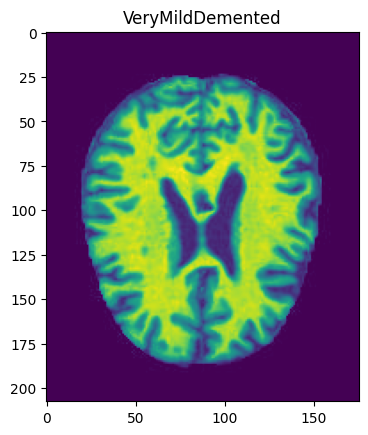

In [16]:
for label in labels:
    path = os.listdir(dir + '/' + label)
    img = dir + '/' + label + '/' + path[1]
    plt.title(label)

    image = mpimg.imread(img)
    plt.imshow(image)
    plt.show()

# Normal CNN

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 62, 62, 8)         80        
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 31, 31, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 29, 29, 16)        1168      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 6, 6, 32)        

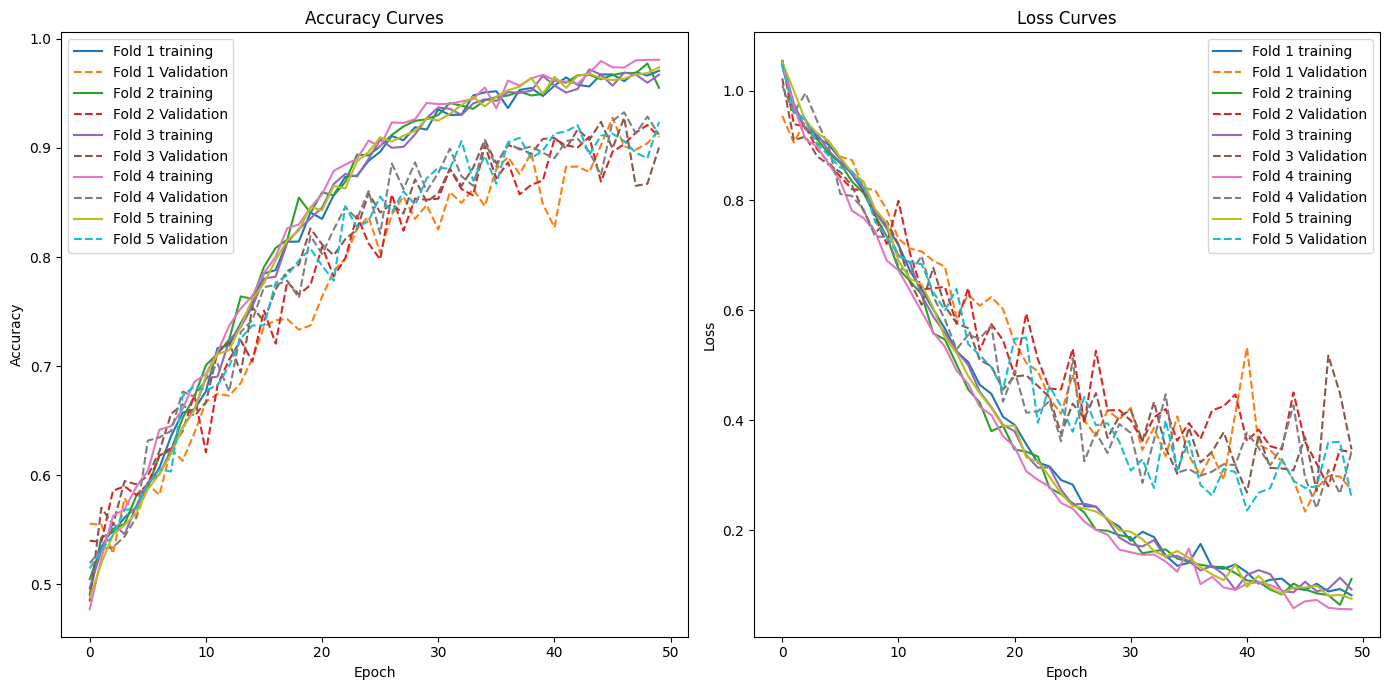

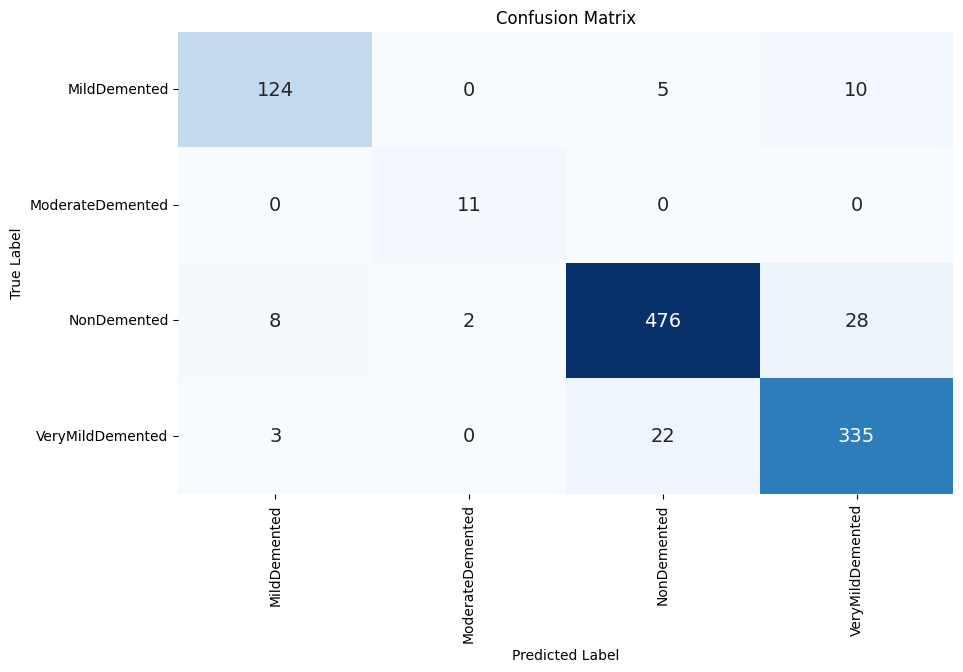

Classification Report
                  precision    recall  f1-score   support

    MildDemented       0.92      0.89      0.91       139
ModerateDemented       0.85      1.00      0.92        11
     NonDemented       0.95      0.93      0.94       514
VeryMildDemented       0.90      0.93      0.91       360

        accuracy                           0.92      1024
       macro avg       0.90      0.94      0.92      1024
    weighted avg       0.92      0.92      0.92      1024



In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.summary()
    
    return model

def train_model(model, augmented_train_data, X_val, y_val, fold_num):
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
    checkpoint = ModelCheckpoint(f'fold_{fold_num}_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    history = model.fit(augmented_train_data, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint])
    return history

def augment_images(X_train, y_train):
    datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0, height_shift_range=0, shear_range=0.1,
                                 zoom_range=0, horizontal_flip=False, vertical_flip=False)
    datagen.fit(X_train)
    return datagen.flow(X_train, y_train, batch_size=32)

# Load and preprocess the images

def load_and_preprocess_images(directory):
    image_data = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = Image.open(image_path).resize((64, 64))  # Resize the image to 64x64
            image = np.array(image) / 255.0  # Normalize the pixel values between 0 and 1
            image_data.append(image)
            labels.append(label)

    image_data = np.array(image_data)
    labels = np.array(labels)
    return image_data, labels

# Split the dataset into training and testing sets

def split_dataset(image_data, labels, test_size):
    X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=test_size, random_state=42)

    # Reshape the input data to include the batch size
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)

    # Encode the target labels into integer values
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    # Determine the number of classes
    num_classes = len(label_encoder.classes_)

    # One-hot encode the target labels
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    return X_train, X_test, y_train, y_test, label_encoder

# Perform five-fold cross-validation and train the model for each fold

def perform_cross_validation(X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_histories = []
    fold_results = []

    for fold_num, (train_index, val_index) in enumerate(kf.split(X_train), 1):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Create the model
        model = create_model(input_shape=X_train_fold.shape[1:], num_classes=y_train_fold.shape[1])
        
        # Augment training images
        augmented_train_data = augment_images(X_train_fold, y_train_fold)
        
        # Train the model on the current fold
        print(f"Training on Fold {fold_num}...")
        history = train_model(model, augmented_train_data, X_val_fold, y_val_fold, fold_num)
        
        y_pred = np.argmax(model.predict(X_val_fold), axis=1)
        y_true = np.argmax(y_val_fold, axis=1)
        fold_results.append((y_true, y_pred))
        
        fold_histories.append(history)
        print(f"Training on Fold {fold_num} completed.\n")
    
    return fold_histories, fold_results

# Plot accuracy and loss curves for each fold

def plot_fold_curves(fold_histories, fold_results):
    num_folds = len(fold_histories)
    plt.figure(figsize=(14, 7))

    # Plot accuracy curves
    plt.subplot(1, 2, 1)
    for fold_num, history in enumerate(fold_histories, 1):
        plt.plot(history.history['accuracy'], label=f'Fold {fold_num} training')
        plt.plot(history.history['val_accuracy'], '--', label=f'Fold {fold_num} Validation')
    plt.title('Accuracy Curves', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    # Plot loss curves
    plt.subplot(1, 2, 2)
    for fold_num, history in enumerate(fold_histories, 1):
        plt.plot(history.history['loss'], label=f'Fold {fold_num} training')
        plt.plot(history.history['val_loss'], '--', label=f'Fold {fold_num} Validation')
    plt.title('Loss Curves', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

    # Plot confusion matrices

    best_fold_index = np.argmax([history.history['val_accuracy'][-1] for history in fold_histories])
    best_fold_y_true, best_fold_y_pred = fold_results[best_fold_index]

    plt.figure(figsize=(10, 6))
    best_fold_cm = confusion_matrix(best_fold_y_true, best_fold_y_pred)
    sns.heatmap(best_fold_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=False, annot_kws={"fontsize": 20})
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

def generate_classification_report(fold_results, label_encoder, best_fold_index):
    y_true, y_pred = fold_results[best_fold_index]
    y_true_labels = label_encoder.inverse_transform(y_true)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    report = classification_report(y_true_labels, y_pred_labels)
    print("Classification Report")
    print(report)
    print("=" * 50)

    # Plot the model architecture

# Main code

dir = r'D:\Alzeimheir\Alzheimer_s Dataset'
image_data, labels = load_and_preprocess_images(dir)
X_train, X_test, y_train, y_test, label_encoder = split_dataset(image_data, labels, test_size=0.2)
fold_histories, fold_results = perform_cross_validation(X_train, y_train)
best_fold_index = np.argmax([history.history['val_accuracy'][-1] for history in fold_histories])
plot_fold_curves(fold_histories, fold_results)
generate_classification_report(fold_results, label_encoder, best_fold_index)


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 62, 62, 8)         80        
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 31, 31, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_105 (Conv2D)         (None, 29, 29, 16)        1168      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_106 (Conv2D)         (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 6, 6, 32)       

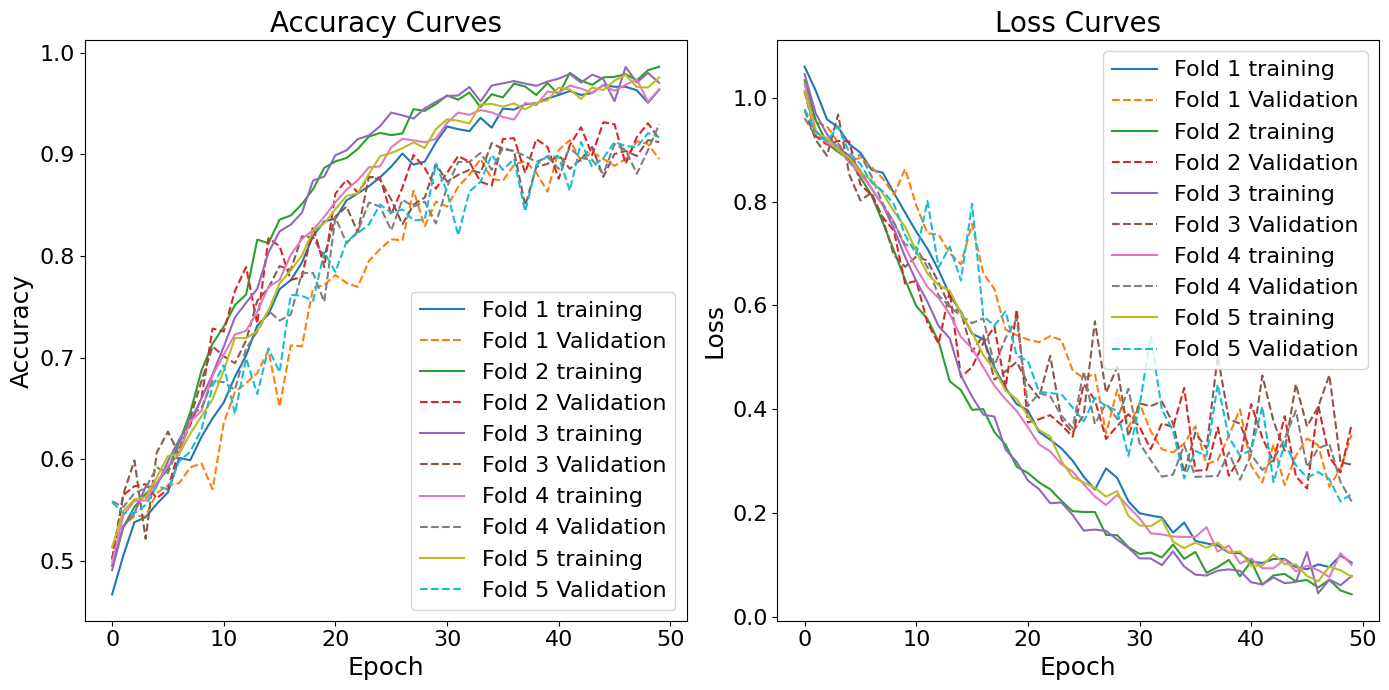

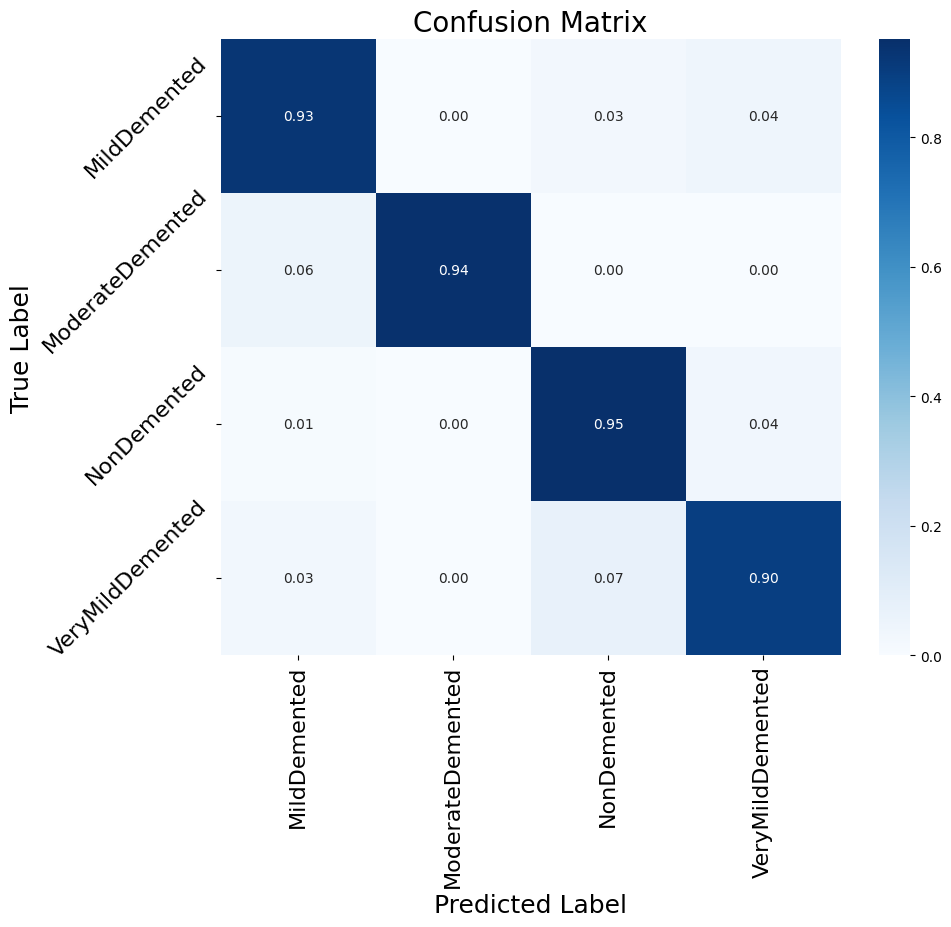

Classification Report for Fold 1:
                  precision    recall  f1-score   support

    MildDemented       0.83      0.98      0.90       138
ModerateDemented       1.00      1.00      1.00         8
     NonDemented       0.89      0.96      0.92       524
VeryMildDemented       0.94      0.77      0.85       354

        accuracy                           0.90      1024
       macro avg       0.91      0.93      0.92      1024
    weighted avg       0.90      0.90      0.89      1024

Classification Report for Fold 2:
                  precision    recall  f1-score   support

    MildDemented       0.85      0.89      0.87       145
ModerateDemented       1.00      1.00      1.00        11
     NonDemented       0.94      0.93      0.93       507
VeryMildDemented       0.90      0.90      0.90       361

        accuracy                           0.92      1024
       macro avg       0.92      0.93      0.93      1024
    weighted avg       0.92      0.92      0.92      1024

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.summary()
    
    return model

def train_model(model, augmented_train_data, X_val, y_val, fold_num):
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
    checkpoint = ModelCheckpoint(f'fold_{fold_num}_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    history = model.fit(augmented_train_data, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint])
    return history

def augment_images(X_train, y_train):
    datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0, height_shift_range=0, shear_range=0.1,
                                 zoom_range=0, horizontal_flip=False, vertical_flip=False)
    datagen.fit(X_train)
    return datagen.flow(X_train, y_train, batch_size=32)

# Load and preprocess the images

def load_and_preprocess_images(directory):
    image_data = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = Image.open(image_path).resize((64, 64))  # Resize the image to 64x64
            image = np.array(image) / 255.0  # Normalize the pixel values between 0 and 1
            image_data.append(image)
            labels.append(label)

    image_data = np.array(image_data)
    labels = np.array(labels)
    return image_data, labels

# Split the dataset into training and testing sets

def split_dataset(image_data, labels, test_size):
    X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=test_size, random_state=42)

    # Reshape the input data to include the batch size
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)

    # Encode the target labels into integer values
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    # Determine the number of classes
    num_classes = len(label_encoder.classes_)

    # One-hot encode the target labels
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    return X_train, X_test, y_train, y_test, label_encoder

# Perform five-fold cross-validation and train the model for each fold

def perform_cross_validation(X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_histories = []
    fold_results = []

    for fold_num, (train_index, val_index) in enumerate(kf.split(X_train), 1):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Create the model
        model = create_model(input_shape=X_train_fold.shape[1:], num_classes=y_train_fold.shape[1])
        
        # Augment training images
        augmented_train_data = augment_images(X_train_fold, y_train_fold)
        
        # Train the model on the current fold
        print(f"Training on Fold {fold_num}...")
        history = train_model(model, augmented_train_data, X_val_fold, y_val_fold, fold_num)
        
        y_pred = np.argmax(model.predict(X_val_fold), axis=1)
        y_true = np.argmax(y_val_fold, axis=1)
        fold_results.append((y_true, y_pred))
        
        fold_histories.append(history)
        print(f"Training on Fold {fold_num} completed.\n")
    
    return fold_histories, fold_results

# Plot accuracy and loss curves for each fold

def plot_fold_curves(fold_histories, fold_results):
    num_folds = len(fold_histories)
    plt.figure(figsize=(14, 7))

    # Plot accuracy curves
    plt.subplot(1, 2, 1)
    for fold_num, history in enumerate(fold_histories, 1):
        plt.plot(history.history['accuracy'], label=f'Fold {fold_num} training')
        plt.plot(history.history['val_accuracy'], '--', label=f'Fold {fold_num} Validation')
    plt.title('Accuracy Curves', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    # Plot loss curves
    plt.subplot(1, 2, 2)
    for fold_num, history in enumerate(fold_histories, 1):
        plt.plot(history.history['loss'], label=f'Fold {fold_num} training')
        plt.plot(history.history['val_loss'], '--', label=f'Fold {fold_num} Validation')
    plt.title('Loss Curves', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix for the best accuracy fold

    best_fold_index = np.argmax([history.history['val_accuracy'][-1] for history in fold_histories])
    best_fold_y_true, best_fold_y_pred = fold_results[best_fold_index]
    labels = label_encoder.classes_

    cm = confusion_matrix(best_fold_y_true, best_fold_y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.xticks(rotation=90,fontsize=16)
    plt.yticks(rotation=45,fontsize=16)
    plt.show()

    # Classification report for each fold

    for fold_num, (y_true, y_pred) in enumerate(fold_results, 1):
        print(f"Classification Report for Fold {fold_num}:")
        print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Main
dir = r'D:\Alzeimheir\Alzheimer_s Dataset'

image_data, labels = load_and_preprocess_images(dir)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, label_encoder = split_dataset(image_data, labels, test_size=0.2)

fold_histories, fold_results = perform_cross_validation(X_train, y_train)

plot_fold_curves(fold_histories, fold_results)


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

def create_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model


def train_model(model, augmented_train_data, X_val, y_val, fold_num):
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
    checkpoint = ModelCheckpoint(f'fold_{fold_num}_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    history = model.fit(augmented_train_data, validation_data=(X_val, y_val), epochs=2, callbacks=[checkpoint])
    return history

def augment_images(X_train, y_train):
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
                                 zoom_range=0.1, horizontal_flip=False, vertical_flip=False)
    datagen.fit(X_train)
    return datagen.flow(X_train, y_train, batch_size=32)

# Load and preprocess the images

def load_and_preprocess_images(directory):
    image_data = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = Image.open(image_path).resize((64, 64))  # Updated size to (224, 224)
            image_rgb = image.convert('RGB')  # Convert grayscale to RGB
            image_array = np.array(image_rgb) / 255.0
            image_data.append(image_array)
            labels.append(label)

    image_data = np.array(image_data)
    labels = np.array(labels)
    return image_data, labels

# Split the dataset into training and testing sets

def split_dataset(image_data, labels, test_size):
    X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=test_size, random_state=42)

    # Reshape the input data to include the channel dimension
    X_train = X_train.reshape(X_train.shape[0], 64, 64, 3)
    X_test = X_test.reshape(X_test.shape[0], 64, 64, 3)

    # Encode the target labels into integer values
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    # Determine the number of classes
    num_classes = len(label_encoder.classes_)

    # One-hot encode the target labels
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    return X_train, X_test, y_train, y_test, label_encoder

# Perform five-fold cross-validation and train the model for each fold

def perform_cross_validation_resnet50(X_train, y_train):
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    fold_histories = []
    fold_results = []

    for fold_num, (train_index, val_index) in enumerate(kf.split(X_train), 1):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Create the VGG16 model
        input_shape = X_train_fold.shape[1:]
        num_classes = y_train_fold.shape[1]
        model = create_resnet50_model(input_shape=input_shape, num_classes=num_classes)

        # Train the model on the current fold
        print(f"Training ResNet50 on Fold {fold_num}...")
        model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
        checkpoint = ModelCheckpoint(f'fold_{fold_num}_resnet50_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, callbacks=[checkpoint])

        y_pred = np.argmax(model.predict(X_val_fold), axis=1)
        y_true = np.argmax(y_val_fold, axis=1)
        fold_results.append((y_true, y_pred))

        fold_histories.append(history)
        print(f"Training resnet50 on Fold {fold_num} completed.\n")

    return fold_histories, fold_results


# Plot accuracy and loss curves for each fold

def plot_fold_curves(fold_histories, fold_results):
    num_folds = len(fold_histories)
    plt.figure(figsize=(14, 7))

    # Plot accuracy curves
    plt.subplot(1, 2, 1)
    for fold_num, history in enumerate(fold_histories, 1):
        plt.plot(history.history['accuracy'], label=f'Fold {fold_num} training')
        plt.plot(history.history['val_accuracy'], '--', label=f'Fold {fold_num} Validation')
    plt.title('Accuracy Curves', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    # Plot loss curves
    plt.subplot(1, 2, 2)
    for fold_num, history in enumerate(fold_histories, 1):
        plt.plot(history.history['loss'], label=f'Fold {fold_num} training')
        plt.plot(history.history['val_loss'], '--', label=f'Fold {fold_num} Validation')
    plt.title('Loss Curves', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix for the best accuracy fold

    best_fold_index = np.argmax([history.history['val_accuracy'][-1] for history in fold_histories])
    best_fold_y_true, best_fold_y_pred = fold_results[best_fold_index]
    labels = label_encoder.classes_

    cm = confusion_matrix(best_fold_y_true, best_fold_y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.xticks(rotation=90,fontsize=16)
    plt.yticks(rotation=45,fontsize=16)
    plt.show()

    # Classification report for each fold

    for fold_num, (y_true, y_pred) in enumerate(fold_results, 1):
        print(f"Classification Report for Fold {fold_num}:")
        print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Main code

dir = r'D:\Alzeimheir\Alzheimer_s Dataset'
image_data, labels = load_and_preprocess_images(dir)
X_train, X_test, y_train, y_test, label_encoder = split_dataset(image_data, labels, test_size=0.2)
fold_histories, fold_results = perform_cross_validation_resnet50(X_train, y_train)
best_fold_index = np.argmax([history.history['val_accuracy'][-1] for history in fold_histories])
plot_fold_curves(fold_histories, fold_results)


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_77 (Dense)            (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________
Training ResNet50 on Fold 1...
Epoch 1/50
 4/80 [>.............................] - ETA: 3:51 - loss: 2.0051 - accuracy: 0.3750

KeyboardInterrupt: 

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

def create_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model


def train_model(model, augmented_train_data, X_val, y_val, fold_num):
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
    checkpoint = ModelCheckpoint(f'fold_{fold_num}_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    history = model.fit(augmented_train_data, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint])
    return history

def augment_images(X_train, y_train):
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0, height_shift_range=0, shear_range=0.1,
                                 zoom_range=0.1, horizontal_flip=False, vertical_flip=False)
    datagen.fit(X_train)
    return datagen.flow(X_train, y_train, batch_size=32)

# Load and preprocess the images

def load_and_preprocess_images(directory):
    image_data = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = Image.open(image_path).resize((64, 64))  # Updated size to (224, 224)
            image_rgb = image.convert('RGB')  # Convert grayscale to RGB
            image_array = np.array(image_rgb) / 255.0
            image_data.append(image_array)
            labels.append(label)

    image_data = np.array(image_data)
    labels = np.array(labels)
    return image_data, labels

# Split the dataset into training and testing sets

def split_dataset(image_data, labels, test_size):
    X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=test_size, random_state=42)

    # Reshape the input data to include the channel dimension
    X_train = X_train.reshape(X_train.shape[0], 64, 64, 3)
    X_test = X_test.reshape(X_test.shape[0], 64, 64, 3)

    # Encode the target labels into integer values
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    # Determine the number of classes
    num_classes = len(label_encoder.classes_)

    # One-hot encode the target labels
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    return X_train, X_test, y_train, y_test, label_encoder

# Perform five-fold cross-validation and train the model for each fold

def perform_cross_validation_vgg16(X_train, y_train):
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    fold_histories = []
    fold_results = []

    for fold_num, (train_index, val_index) in enumerate(kf.split(X_train), 1):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Create the VGG16 model
        input_shape = X_train_fold.shape[1:]
        num_classes = y_train_fold.shape[1]
        model = create_vgg16_model(input_shape=input_shape, num_classes=num_classes)

        # Train the model on the current fold
        print(f"Training VGG16 on Fold {fold_num}...")
        model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
        checkpoint = ModelCheckpoint(f'fold_{fold_num}_vgg16_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, callbacks=[checkpoint])

        y_pred = np.argmax(model.predict(X_val_fold), axis=1)
        y_true = np.argmax(y_val_fold, axis=1)
        fold_results.append((y_true, y_pred))

        fold_histories.append(history)
        print(f"Training VGG16 on Fold {fold_num} completed.\n")

    return fold_histories, fold_results


# Plot accuracy and loss curves for each fold

def plot_fold_curves(fold_histories, fold_results):
    num_folds = len(fold_histories)
    plt.figure(figsize=(14, 7))

    # Plot accuracy curves
    plt.subplot(1, 2, 1)
    for fold_num, history in enumerate(fold_histories, 1):
        plt.plot(history.history['accuracy'], label=f'Fold {fold_num} training')
        plt.plot(history.history['val_accuracy'], '--', label=f'Fold {fold_num} Validation')
    plt.title('Accuracy Curves', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    # Plot loss curves
    plt.subplot(1, 2, 2)
    for fold_num, history in enumerate(fold_histories, 1):
        plt.plot(history.history['loss'], label=f'Fold {fold_num} training')
        plt.plot(history.history['val_loss'], '--', label=f'Fold {fold_num} Validation')
    plt.title('Loss Curves', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix for the best accuracy fold

    best_fold_index = np.argmax([history.history['val_accuracy'][-1] for history in fold_histories])
    best_fold_y_true, best_fold_y_pred = fold_results[best_fold_index]
    labels = label_encoder.classes_

    cm = confusion_matrix(best_fold_y_true, best_fold_y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.xticks(rotation=90,fontsize=16)
    plt.yticks(rotation=45,fontsize=16)
    plt.show()

    # Classification report for each fold

    for fold_num, (y_true, y_pred) in enumerate(fold_results, 1):
        print(f"Classification Report for Fold {fold_num}:")
        print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Main code
dir = r'D:\Alzeimheir\Alzheimer_s Dataset'
image_data, labels = load_and_preprocess_images(dir)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, label_encoder = split_dataset(image_data, labels, test_size=0.2)
fold_histories, fold_results = perform_cross_validation_vgg16(X_train, y_train)
plot_fold_curves(fold_histories, fold_results)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_38 (Flatten)        (None, 2048)              0         
                                                                 
 dense_78 (Dense)            (None, 4096)              8392704   
                                                                 
 dense_79 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_80 (Dense)            (None, 4)                 16388     
                                                                 
Total params: 39,905,092
Trainable params: 39,905,092
Non-trainable params: 0
_________________________________________________________________
Training VGG16 on Fold 1...
Epoch 1/50


KeyboardInterrupt: 

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

def create_xception_model(input_shape, num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model


def train_model(model, augmented_train_data, X_val, y_val, fold_num):
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
    checkpoint = ModelCheckpoint(f'fold_{fold_num}_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    history = model.fit(augmented_train_data, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint])
    return history

def augment_images(X_train, y_train):
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0, height_shift_range=0, shear_range=0.1,
                                 zoom_range=0.1, horizontal_flip=False, vertical_flip=False)
    datagen.fit(X_train)
    return datagen.flow(X_train, y_train, batch_size=32)

# Load and preprocess the images

def load_and_preprocess_images(directory):
    image_data = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = Image.open(image_path).resize((71, 71))
            image_rgb = image.convert('RGB')  # Convert grayscale to RGB
            image_array = np.array(image_rgb) / 255.0
            image_data.append(image_array)
            labels.append(label)

    image_data = np.array(image_data)
    labels = np.array(labels)
    return image_data, labels

# Split the dataset into training and testing sets

def split_dataset(image_data, labels, test_size):
    X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=test_size, random_state=42)

    # Reshape the input data to include the channel dimension
    X_train = X_train.reshape(X_train.shape[0], 71, 71, 3)
    X_test = X_test.reshape(X_test.shape[0], 71, 71, 3)

    # Encode the target labels into integer values
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    # Determine the number of classes
    num_classes = len(label_encoder.classes_)

    # One-hot encode the target labels
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    return X_train, X_test, y_train, y_test, label_encoder

# Perform five-fold cross-validation and train the model for each fold

def perform_cross_validation_xception(X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_histories = []
    fold_results = []

    for fold_num, (train_index, val_index) in enumerate(kf.split(X_train), 1):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Create the Xception model
        input_shape = X_train_fold.shape[1:]
        num_classes = y_train_fold.shape[1]
        model = create_xception_model(input_shape=input_shape, num_classes=num_classes)

        # Train the model on the current fold
        print(f"Training Xception on Fold {fold_num}...")
        model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
        checkpoint = ModelCheckpoint(f'fold_{fold_num}_xception_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, callbacks=[checkpoint])

        y_pred = np.argmax(model.predict(X_val_fold), axis=1)
        y_true = np.argmax(y_val_fold, axis=1)
        fold_results.append((y_true, y_pred))

        fold_histories.append(history)
        print(f"Training Xception on Fold {fold_num} completed.\n")

    return fold_histories, fold_results


# Plot accuracy and loss curves for each fold

def plot_fold_curves(fold_histories, fold_results):
    num_folds = len(fold_histories)
    plt.figure(figsize=(14, 7))

    # Plot accuracy curves
    plt.subplot(1, 2, 1)
    for fold_num, history in enumerate(fold_histories, 1):
        plt.plot(history.history['accuracy'], label=f'Fold {fold_num} training')
        plt.plot(history.history['val_accuracy'], '--', label=f'Fold {fold_num} Validation')
    plt.title('Accuracy Curves', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    # Plot loss curves
    plt.subplot(1, 2, 2)
    for fold_num, history in enumerate(fold_histories, 1):
        plt.plot(history.history['loss'], label=f'Fold {fold_num} training')
        plt.plot(history.history['val_loss'], '--', label=f'Fold {fold_num} Validation')
    plt.title('Loss Curves', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix for the best accuracy fold

    best_fold_index = np.argmax([history.history['val_accuracy'][-1] for history in fold_histories])
    best_fold_y_true, best_fold_y_pred = fold_results[best_fold_index]
    labels = label_encoder.classes_

    cm = confusion_matrix(best_fold_y_true, best_fold_y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.xticks(rotation=90,fontsize=16)
    plt.yticks(rotation=45,fontsize=16)
    plt.show()

    # Classification report for each fold

    for fold_num, (y_true, y_pred) in enumerate(fold_results, 1):
        print(f"Classification Report for Fold {fold_num}:")
        print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


# Main code

dir = r'D:\Alzeimheir\Alzheimer_s Dataset'  # Replace with the actual path to your dataset
image_data, labels = load_and_preprocess_images(dir)
X_train, X_test, y_train, y_test, label_encoder = split_dataset(image_data, labels, test_size=0.2)
fold_histories, fold_results = perform_cross_validation_xception(X_train, y_train)
plot_fold_curves(fold_histories, fold_results)


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_81 (Dense)            (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________
Training Xception on Fold 1...
Epoch 1/50


KeyboardInterrupt: 